# Analysis of CO2 Emissions by Type of Energy Production

### Setup Imports/Variables

In [108]:
#Import Dependancies
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress
import scipy.stats as stats
import numpy as np

In [2]:
#Get CSV Paths
cleanedPath = os.path.join('..', 'Outputs', 'cleaned_data.csv')
electricityPath = os.path.join('..', 'Resources', 'electricity_production.csv')

In [3]:
#Read Cleaned CSV and Raw Electricity Production
cleanedDF = pd.read_csv(cleanedPath)
electricDF = pd.read_csv(electricityPath)

### Plot CO2 Emissions vs Non-Renewable Energy Usage

The r-value is 0.9909881751638729


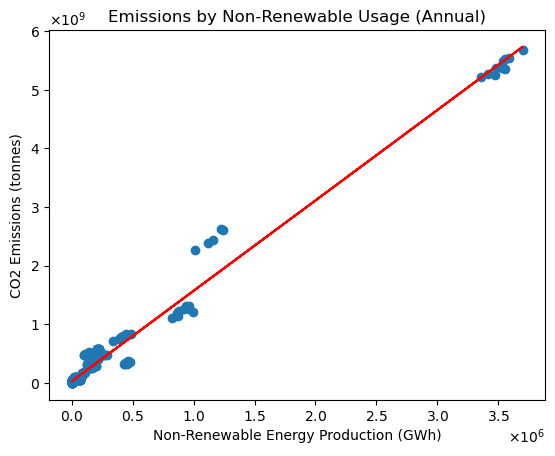

In [151]:
#Scatter Plot with CO2 Emissions and Non-Renewable Energy Usage
x_values = cleanedDF['Non-Renewables Value']
y_values = cleanedDF['CO2 Emissions']
plt.scatter(x=x_values, y=y_values)
plt.title('Emissions by Non-Renewable Usage (Annual)')
plt.xlabel('Non-Renewable Energy Production (GWh)')
plt.ylabel('CO2 Emissions (tonnes)')

#Add Regress Values
(slope, intercept, rvalue, pvalue, stdev) = linregress(x_values, y_values)
regressValues = x_values * slope + intercept
plt.plot(x_values, regressValues, 'r-')
plt.ticklabel_format(useOffset=False,useMathText=True)
print(f'The r-value is {rvalue}')

### T-Test for statistical significance

In [5]:
stats.ttest_ind(x_values, y_values, equal_var=False)

Ttest_indResult(statistic=-7.2840826768257125, pvalue=2.161358976595285e-12)

##### With a p-value of notably less than 0.05, the correlation between Non-Renewable Energy Production and CO2 Emissions is statistically significant

### Check Distribution of Types of Energy Produced vs CO2 Emissions

#### Rearrange Electricity Production DataFrame 

In [6]:
#Select Desired Rows
cleanEleDF = electricDF[['COUNTRY', 'YEAR', 'MONTH', 'PRODUCT', 'yearToDate', 'share']]
cleanEleDF = cleanEleDF.loc[cleanEleDF['MONTH'] == 12]
cleanEleDF = cleanEleDF.drop(columns=['MONTH'])
cleanEleDF = cleanEleDF.rename(columns={'COUNTRY':'Country Name', 'YEAR':'Year', 'PRODUCT':'Fuel Type', 'yearToDate': 'Value', 'share':'Share'})
cleanEleDF = cleanEleDF.loc[(cleanEleDF['Fuel Type'] == 'Hydro') | (cleanEleDF['Fuel Type'] == 'Wind') |
                            (cleanEleDF['Fuel Type'] == 'Solar') | (cleanEleDF['Fuel Type'] == 'Geothermal') |
                            (cleanEleDF['Fuel Type'] == 'Coal') | (cleanEleDF['Fuel Type'] == 'Oil') |
                            (cleanEleDF['Fuel Type'] == 'Natural gas') | (cleanEleDF['Fuel Type'] == 'Net electricity production')]

In [7]:
#Move Type rows to Columns
for type in cleanEleDF['Fuel Type'].unique():
    tempDF = cleanEleDF.loc[cleanEleDF['Fuel Type'] == type]
    cleanEleDF[f'{type} Value'] = tempDF['Value']
    cleanEleDF[f'{type} Share'] = tempDF['Share']

cleanEleDF = cleanEleDF.drop(columns=['Value', 'Share'])
cleanEleDF = cleanEleDF.groupby(['Country Name', 'Year']).mean()
cleanEleDF = cleanEleDF.reset_index()

In [34]:
#Filter to Countries in Cleaned DataFrame, add Emissions
matchedCountries = [x for x in cleanEleDF['Country Name'].unique() if x in cleanedDF['Country Name'].unique()]
matchedDF = cleanEleDF.loc[cleanEleDF['Country Name'].isin(matchedCountries)]
matchedDF = matchedDF.loc[matchedDF['Year']<=2019]
matchedDF = matchedDF.reset_index()
matchedDF['CO2 Emissions'] = cleanedDF['CO2 Emissions']

In [55]:
#Get top 5 and bottom 5 CO2 Emissions
totEmissions = (matchedDF.groupby(by='Country Name')['CO2 Emissions'].mean()) / (matchedDF.groupby(by='Country Name')['Net electricity production Value'].mean())
totEmissions = totEmissions.sort_values(ascending=False)
top5 = totEmissions.head(5).index
totEmissions = totEmissions.sort_values(ascending=True)
bot5 = totEmissions.head(5).index
topDF = matchedDF.loc[matchedDF['Country Name'].isin(top5)]
botDF = matchedDF.loc[matchedDF['Country Name'].isin(bot5)]

In [83]:
#Get Mean of each Energy Type
types = ['Hydro Share', 'Wind Share', 'Solar Share', 'Geothermal Share', 'Coal Share', 'Oil Share', 'Natural gas Share']
def getEnergyMeans(df: pd.DataFrame):
    outputDF = pd.DataFrame()
    for type in types:
        outputDF[type] = df.groupby('Country Name')[type].mean()
    return(outputDF)
topMeanDF = getEnergyMeans(topDF)
botMeanDF = getEnergyMeans(botDF)

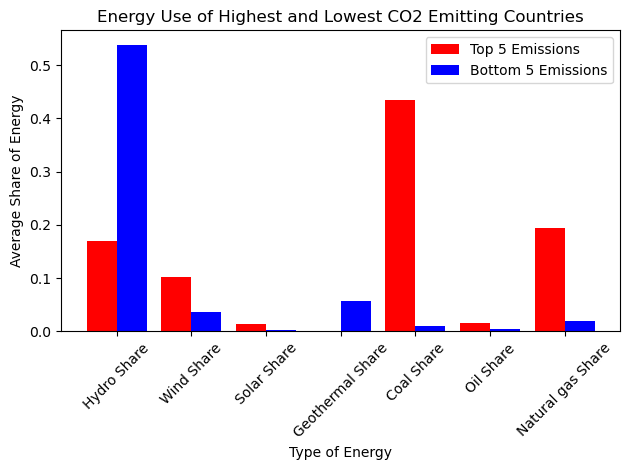

In [129]:
#Plot Top5 and Bot5 By Energy Use
x_axis = np.arange(len(types))
plt.bar(x=x_axis-0.2, height=topMeanDF.mean(), color='r', align='center', width=0.4, label='Top 5 Emissions')
plt.bar(x=x_axis+0.2, height=botMeanDF.mean(), color='b', align='center', width=0.4, label='Bottom 5 Emissions')
plt.xticks(x_axis, types, rotation=45)
plt.xlabel('Type of Energy')
plt.ylabel('Average Share of Energy')
plt.title('Energy Use of Highest and Lowest CO2 Emitting Countries')
plt.legend(loc='upper right')
plt.tight_layout()